In [120]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("/root/cat2"))

['cat1', 'images.zip']


In [121]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
#from torch.autograd import Variable
import torch.optim as optim

import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [122]:
batch_size = 32
image_size = 64

# Learning rate for optimizers
lr = 0.0002

# Number of channels 
channels = 3

# Number of training epochs
epochs = 150

# Latent vector (i.e Size of generator input)
latentVec = 100

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. 0 for cuda mode.
ngpu = 1

# Size of feature maps in generator
FeaGen = 64

# Size of feature maps in discriminator
FeaDis = 64

In [123]:
# Decide which device we want to run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crop 64x64 image
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataloader
train_data = datasets.ImageFolder("/root/cat2", transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [124]:
torch.cuda.is_available()

True

In [110]:
cd /root/cat2

/root/cat2


In [91]:
ls -a

./  ../  cat1/  images.zip  .ipynb_checkpoints/


In [92]:
rm -rf .ipynb_checkpoints

In [93]:
ls -a

./  ../  cat1/


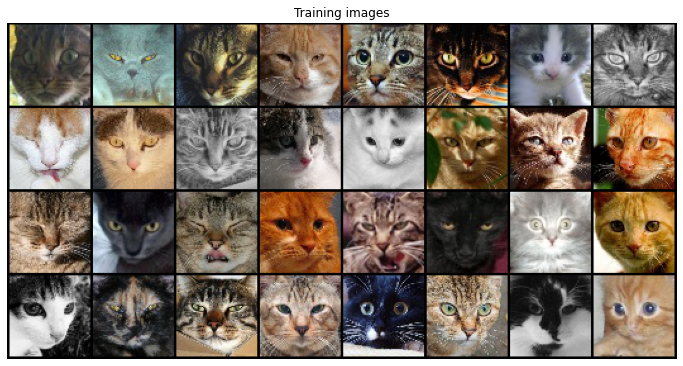

In [125]:
TrainingImages = next(iter(train_loader))
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(TrainingImages[0].to(device)[:64], padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

In [126]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [127]:
class Generator(nn.Module):
    
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latentVec, FeaGen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FeaGen * 8),
            nn.ReLU(True),
            # State size. (FeaGen x 8) x 4 x 4 
            nn.ConvTranspose2d(FeaGen * 8, FeaGen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 4),
            nn.ReLU(True),
            # State size. (FeaGen x 4) x 8 x 8 
            nn.ConvTranspose2d(FeaGen * 4, FeaGen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 2),
            nn.ReLU(True),
            # State size. (FeaGen x 2) x 16 x 16
            nn.ConvTranspose2d(FeaGen * 2, FeaGen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen),
            nn.ReLU(True),
            # State size. FeaGen x 32 x 32
            nn.ConvTranspose2d(FeaGen, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size. (channels) x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [128]:
class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, FeaDis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis) x 32 x 32
            nn.Conv2d(FeaDis, FeaDis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 2) x 16 x 16
            nn.Conv2d(FeaDis * 2, FeaDis * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 4) x 8 x 8
            nn.Conv2d(FeaDis * 4, FeaDis * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 8) x 4 x 4
            nn.Conv2d(FeaDis * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [129]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latentVec, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [130]:
Glosses = []
Dlosses = []
iters = 0
num_epochs = 60

# For each epoch
for epoch in range(num_epochs):
    # For each batch in dataloader
    for i, data in enumerate(train_loader, 0):
        
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with real batch
        netD.zero_grad()
        realImg = data[0].to(device)
        batch_size = realImg.size(0)
        labels = torch.full((batch_size,), real_label, device=device)
        
        output = netD(realImg).view(-1)
        output=output.to(torch.float32)
        labels=labels.to(torch.float32)
        Real_Loss = criterion(output, labels)   # Calculate loss
        Real_Loss.backward()                    # Calculate Gradient
        Dx = output.mean().item()
        
        ## Train with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latentVec, 1, 1, device = device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
       
        output=output.squeeze(-1)
        output=output.squeeze(-1)
        output=output.squeeze(-1)

        Fake_Loss = criterion(output, labels)
        Fake_Loss.backward()
        D_G1= output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        DisLoss = Real_Loss + Fake_Loss
        optimizerD.step()
        
        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        labels.fill_(real_label)                # fake labels are real for generator cost
        output = netD(fake)
        output = output.squeeze(-1)
        output = output.squeeze(-1)
        output = output.squeeze(-1)
        GLoss = criterion(output, labels)
        GLoss.backward()
        D_G2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if iters % 50 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D Loss: %.4f] [G Loss: %.4f] [D(x): %.4f] [D(G(z)): %.4f/%.4f]' 
                  % (epoch, num_epochs, i, len(train_loader), DisLoss.item(), GLoss.item(), Dx, D_G1, D_G2))
            
            ValidImage = netG(fixed_noise)
        
        iters += 1
            
        # Save Losses
        Glosses.append(GLoss.item())
        Dlosses.append(DisLoss.item())

[Epoch 0/60] [Batch 0/486] [D Loss: 1.5049] [G Loss: 4.6029] [D(x): 0.4557] [D(G(z)): 0.3731/0.0111]
[Epoch 0/60] [Batch 50/486] [D Loss: 0.5462] [G Loss: 16.4581] [D(x): 0.9089] [D(G(z)): 0.3010/0.0000]
[Epoch 0/60] [Batch 100/486] [D Loss: 2.2287] [G Loss: 22.8503] [D(x): 0.3489] [D(G(z)): 0.0000/0.0000]
[Epoch 0/60] [Batch 150/486] [D Loss: 0.9276] [G Loss: 6.6503] [D(x): 0.8183] [D(G(z)): 0.2740/0.0023]
[Epoch 0/60] [Batch 200/486] [D Loss: 0.4629] [G Loss: 7.0086] [D(x): 0.8813] [D(G(z)): 0.2275/0.0017]
[Epoch 0/60] [Batch 250/486] [D Loss: 0.4296] [G Loss: 5.2853] [D(x): 0.8366] [D(G(z)): 0.1338/0.0252]
[Epoch 0/60] [Batch 300/486] [D Loss: 0.6169] [G Loss: 7.1995] [D(x): 0.9068] [D(G(z)): 0.3239/0.0009]
[Epoch 0/60] [Batch 350/486] [D Loss: 0.3735] [G Loss: 6.5097] [D(x): 0.9571] [D(G(z)): 0.2482/0.0026]
[Epoch 0/60] [Batch 400/486] [D Loss: 0.6646] [G Loss: 4.1128] [D(x): 0.7080] [D(G(z)): 0.1940/0.0277]
[Epoch 0/60] [Batch 450/486] [D Loss: 0.2744] [G Loss: 4.3060] [D(x): 0.89

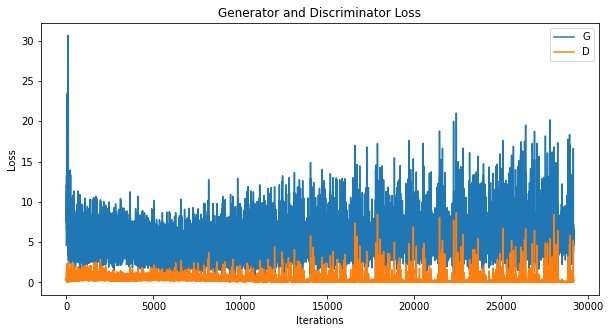

In [131]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [132]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/root/cat2/images.zip'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


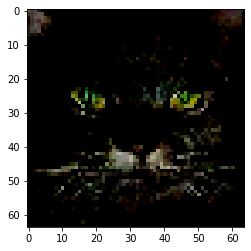

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


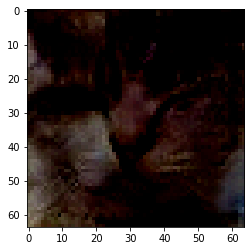

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


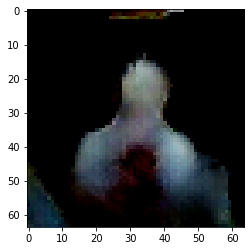

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


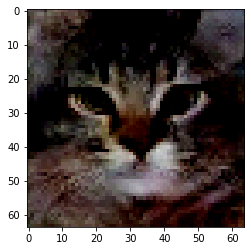

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


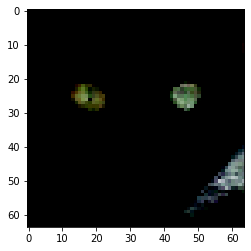

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


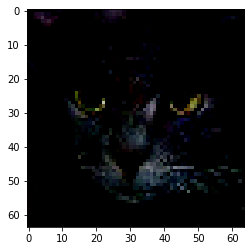

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


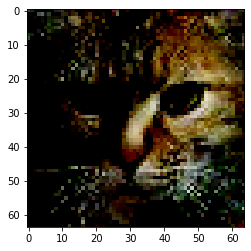

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


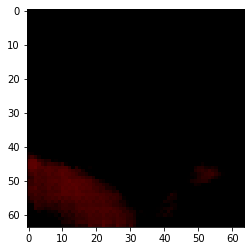

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


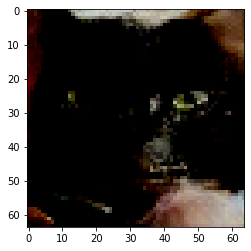

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


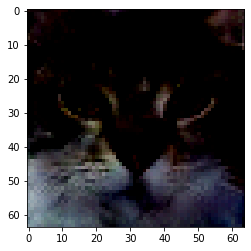

In [133]:
for i in range(10):
    plt.imshow(images[i])
    plt.show()